# Demand Analysis with Time Series method & Inventory Analysis with QR Method

In this project first, we want to predict the demand for 2023-2024 of a specific item in a Warehouse and then try to manage the inventory of this cargo based on the QR method. We use the 5 years old dataset for this project.

Inventory analytics involves analyzing data related to inventory levels, sales, and other relevant metrics to optimize inventory management and improve overall business performance. The goal is to strike a balance between having enough inventory to meet customer demand while minimizing the costs associated with carrying excess inventory.

Inventory levels refer to the amount of inventory that a business has on hand at a given point in time. It includes all the raw materials, work-in-progress goods, and finished products that a business has in its possession. Inventory levels are important because they directly impact a business's ability to meet customer demand and generate revenue.

There are several different inventory policies that businesses can use to manage their inventory levels, including:

1- Just-in-time (JIT) inventory: JIT inventory involves ordering and receiving inventory just in time to meet customer demand. This policy helps reduce inventory carrying costs but requires careful coordination with suppliers to ensure timely delivery.

2- Economic order quantity (EOQ): EOQ is a formula used to calculate the optimal order quantity to minimize inventory carrying costs while meeting demand. This policy is based on the assumption that demand is known and constant.

3- Safety stock: Safety stock is extra inventory held in case of unexpected increases in demand or delays in delivery. This policy helps ensure that customer demand can be met even in unexpected situations but increases inventory carrying costs.

4- ABC analysis: ABC analysis involves categorizing inventory into three categories based on their value to the business. Category A items are high-value items that require close monitoring, while category C items are low-value items that require less attention.

5- First-in, first-out (FIFO): FIFO is a method of inventory management where the oldest inventory is sold first. This policy helps prevent inventory from becoming obsolete but can result in higher inventory carrying costs.

6- The QR policy, also known as the Quantity-Ordered and Receipts policy, is an inventory management policy that is used to balance the costs of holding inventory and ordering inventory. This policy aims to reduce the costs associated with inventory holding while also ensuring that inventory is available when it is needed. Under this policy, the inventory level is continuously monitored. Whenever the inventory level falls below a predefined threshold level (R), also known as Reorder Point (ROP), a replenishment order of fixed quantity (Q), also known as Economic Order Quantity (EOQ), is placed. In this inventory optimization problem, there are two decision variables Q and R.

In this project we want to use the QR policy. For inventory optimizing based on this policy it is needed to answer the following questions:

1- When to purchase (R)?

2- How much to purchase (Q)?

If the demand is perfectly deterministic, then ROP can easily be calculated.


If the demand is stochastic, then the calculation of ROP is rather complex. If the demand during lead time is less than expected, then there will be inventory on hand when the order is received. But if the demand during lead time is more than expected, then there will be inventory stockouts before the order is received and the service is disrupted.
In addition, if the lead time also becomes stochastic, then the situation becomes more worse.

To prevent inventory stockouts, we keep an addition layer of stock, known as 'safety stock (SS)' so as to raise the ROP.
The calculation of safety stock (SS) depends on service level. Service level is a metric to quantify the level of stockouts that can be tolerated in order to meet the desired level of customer satisfaction.

### Demand Forcasting

In [1]:
import warnings
import itertools
from math import *
import numpy as np
import pandas as pd
from scipy.stats import *
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
from datetime import datetime

C:\Users\fadak\AppData\Local\Temp/ipykernel_11848/2060615187.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [98]:
demand_df = pd.read_csv('Warehouse.csv')
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%m/%d/%Y')
demand_df.set_index('Date', inplace=True)

In [99]:
demand_df.head(3)

,Daily_Demand
Date,
2018-01-01,13
2018-01-02,11
2018-01-03,14


In [102]:
# Resample the demand data in monthly interval
demand_ts = demand_df['Daily_Demand'].resample('MS').mean()
demand_ts.head(12)

Date
2018-01-01    10.580645
2018-02-01    11.500000
2018-03-01    15.387097
2018-04-01    17.400000
2018-05-01    17.129032
2018-06-01    20.900000
2018-07-01    21.322581
2018-08-01    19.161290
2018-09-01    17.300000
2018-10-01    15.612903
2018-11-01    19.066667
2018-12-01    12.516129
Freq: MS, Name: Daily_Demand, dtype: float64

### Three Components of a Time Series

* Trend:
A long-term increase or decrease in the data which might not be linear. Sometimes the trend might change with time.

* Seasonality:
Sometimes a time-series exhibits regular fluctuations based on the season (e.g. every week/month/year). Seasonality is always of a fixed and known period.

* Noise/ Residual:
The random variation in the time-series after removing the trend and the seasonal component.

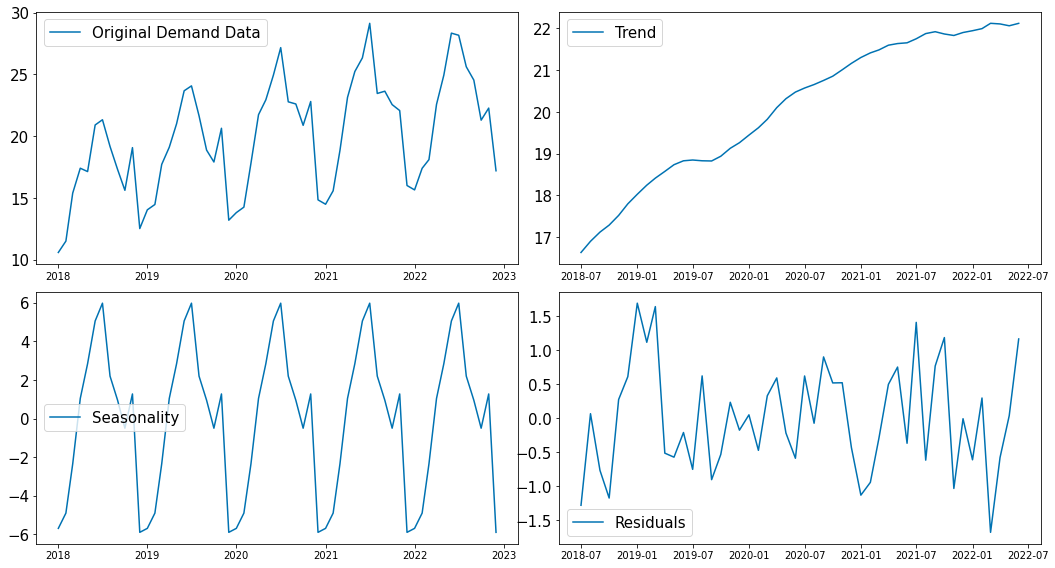

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(demand_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))

plt.subplot(2,2,1)
plt.plot(demand_ts, label='Original Demand Data')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tight_layout()

The data set for demand is given from Jan-2018 to Dec-2022. We need to predict the demand for the whole year of 2023 i.e. from Jan-2023 to Dec-2023. First we predict the demand for the year 2022 and compare the predicted value with the actual value to get an estimate of the accuracy of the model. Then we predict for the year of 2023.

### ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. There ARIMA models are denoted with the notation ARIMA (p, d, q) where three distinct integers 
 are used to parametrize ARIMA models.

* P is the auto-regressive parameter. It allows us to incorporate the effect of past values into our model.

* d is the integrated part. This It allows us to incorporate the amount of differencing into the time series.

* q is the moving-average parameter. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the seasonal ARIMA (p, d, q), which is denoted as ARIMA (p, d, q)(P, D, Q)m. Here (p, d, q), are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The m term is the periodicity of the time series.

The first line define the range of values for the p, d, and q parameters. In this case, they range from 0 to 2. Choosing a range of 0 to 2 for these parameters is a common starting point when trying to fit an ARIMA model to a time series. This range is chosen because it represents a small number of terms, which results in a relatively simple model that is less prone to overfitting the data. However, this range can be expanded or narrowed depending on the complexity of the time series and the accuracy of the model fit.

The next line generates all possible combinations of p, d, and q values using the itertools library.

The next line sets the seasonal periodicity to 12, indicating that the time series has a yearly seasonality. In the seasonal ARIMA model, the parameter m denotes the periodicity of the time series, or the number of time periods in each season. In this case, m is set to 12 because the time series is monthly, and there are 12 months in a year. This means that the model will take into account the seasonality that occurs over each 12-month period.

The next line generates all possible combinations of seasonal p, d, and q values using the itertools library and the seasonal periodicity.

In [111]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
m = 12
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]

The code then loops through all possible combinations of p, d, and q values, as well as seasonal p, d, and q values. For each combination, it tries to fit a SARIMAX model using the statsmodels library, and prints the resulting AIC value. If the fitting process raises an exception, the loop continues to the next combination.

In the following code, results.aic calculates the Akaike Information Criterion (AIC) for each ARIMA model that is fitted to the data.

The AIC is a measure of the quality of the statistical model for a given set of data. It is used to compare models with different numbers of parameters and select the one that best fits the data. The lower the AIC value, the better the model is at describing the data.

The goal is to find the ARIMA model that has the lowest AIC value, indicating the best fit to the data.

In [108]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

lowest_aic = float("inf")
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(demand_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_params = (param, param_seasonal)
        
            print('ARIMA{}x{};  AIC:{:.4f}'.format(param, param_seasonal, results.aic))
        except:
            continue

print("\nBest parameters: ARIMA{}x{}; AIC={:.4f}".format(best_params[0], best_params[1], lowest_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12);  AIC:526.2252
ARIMA(0, 0, 0)x(0, 0, 1, 12);  AIC:387.5633
ARIMA(0, 0, 0)x(0, 1, 0, 12);  AIC:192.6776
ARIMA(0, 0, 0)x(0, 1, 1, 12);  AIC:1426.8975
ARIMA(0, 0, 0)x(1, 0, 0, 12);  AIC:168.3723
ARIMA(0, 0, 0)x(1, 0, 1, 12);  AIC:163.4864
ARIMA(0, 0, 0)x(1, 1, 0, 12);  AIC:125.2692
ARIMA(0, 0, 0)x(1, 1, 1, 12);  AIC:1226.6334
ARIMA(0, 0, 1)x(0, 0, 0, 12);  AIC:455.7878
ARIMA(0, 0, 1)x(0, 0, 1, 12);  AIC:331.2232
ARIMA(0, 0, 1)x(0, 1, 0, 12);  AIC:172.7372
ARIMA(0, 0, 1)x(0, 1, 1, 12);  AIC:1479.1247
ARIMA(0, 0, 1)x(1, 0, 0, 12);  AIC:170.8499
ARIMA(0, 0, 1)x(1, 0, 1, 12);  AIC:162.6201
ARIMA(0, 0, 1)x(1, 1, 0, 12);  AIC:126.2581
ARIMA(0, 0, 1)x(1, 1, 1, 12);  AIC:1535.2282
ARIMA(0, 1, 0)x(0, 0, 0, 12);  AIC:295.0303
ARIMA(0, 1, 0)x(0, 0, 1, 12);  AIC:206.1849
ARIMA(0, 1, 0)x(0, 1, 0, 12);  AIC:162.7409
ARIMA(0, 1, 0)x(0, 1, 1, 12);  AIC:1349.9610
ARIMA(0, 1, 0)x(1, 0, 0, 12);  AIC:163.9115
ARIMA(0, 1, 0)x(1, 0, 1, 12);  AIC:163.1069
ARIMA(0, 1, 0)x(1, 1, 0, 12

Based on the above result, we find out the following combination has the lowest AIC:

ARIMA(1, 1, 1)x(1, 1, 0, 12);  AIC:112.5003

so, it will be chosen.

In [112]:
mod = sm.tsa.statespace.SARIMAX(demand_ts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0640      0.232      0.275      0.783      -0.392       0.519
ma.L1         -0.7550      0.128     -5.900      0.000      -1.006      -0.504
ar.S.L12      -0.0370      0.246     -0.150      0.880      -0.519       0.445
sigma2         1.2663      0.355      3.562      0.000       0.570       1.963


The coefficients column represents the estimated values of the parameters in the model. In this table, there are four coefficients: ar.L1, ma.L1, ma.S.L12, and sigma2.

* ar.L1 and ma.L1 are the coefficients for the autoregressive and moving average terms, respectively, in the non-seasonal part of the model.
* ma.S.L12 is the coefficient for the moving average term in the seasonal part of the model.
* sigma2 is the variance of the error term.

* coef: These are the estimated coefficients for the parameters of the model.
* std err: These are the standard errors associated with each estimated coefficient. They represent the estimated amount of variation in the coefficient due to chance.
* z-score: These are the z-scores associated with each estimated coefficient. They represent the number of standard errors that the estimated coefficient is away from zero.
* P>|z|: These are the p-values associated with each estimated coefficient. They represent the probability of observing a z-score as extreme as the one observed, assuming the null hypothesis that the true coefficient is zero.
* [0.025 0.975]: These are the lower and upper bounds of the 95% confidence interval for each estimated coefficient.

In [113]:
print(results.summary().tables[2])

Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.70   Prob(JB):                         0.53
Heteroskedasticity (H):               1.43   Skew:                             0.33
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.54


This table provides some statistical tests and measures of the goodness of fit for the ARIMA model.

The first row, labeled "Ljung-Box (L1) (Q)", displays the results of a Ljung-Box test for autocorrelation. The null hypothesis of this test is that the residuals are independently distributed (i.e., not autocorrelated).

The second row, labeled "Jarque-Bera (JB)", displays the results of a Jarque-Bera test for normality. The null hypothesis of this test is that the residuals are normally distributed.

The third row, labeled "Heteroskedasticity (H)", displays the results of a test for heteroskedasticity. The null hypothesis of this test is that the residuals have constant variance over time.

Finally, the last row displays the sample skewness and kurtosis of the residuals.

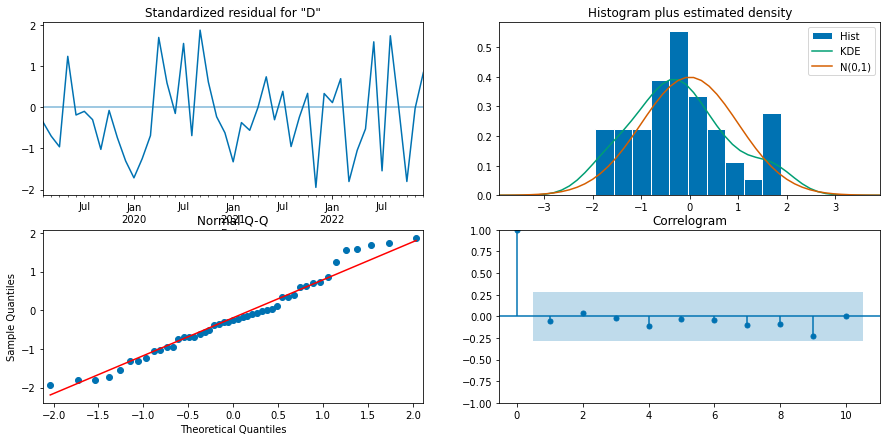

In [114]:
results.plot_diagnostics(figsize=(15, 7))
plt.show()

There is a set of four plots that are commonly used to diagnose whether a time series model is a good fit for the data. These plots are:

1- Standardized Residuals Plot: This plot shows the residuals of the model (the difference between the predicted values and the actual values) as a time series. The residuals should look like white noise, meaning that they should be random and have constant variance across time. Any patterns in the residuals suggest that the model may not be capturing all of the important features of the data.

2- Histogram Plus Estimated Density Plot: This plot shows the distribution of the residuals as a histogram, along with an estimated probability density function (PDF). The PDF should closely match a normal distribution if the model is a good fit for the data.

3- Normal Q-Q Plot: This plot compares the distribution of the residuals to a normal distribution. If the residuals are normally distributed, they should fall along a straight line. Departures from a straight line suggest that the residuals may not be normally distributed.

4- Correlogram: This plot shows the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the residuals. The ACF shows the correlation between each observation and the observations at different lags, while the PACF shows the correlation between each observation and the observations at different lags after controlling for the effects of intervening lags. In a well-specified model, the ACF and PACF should show no significant correlation at any lags, indicating that the residuals are independent and uncorrelated. Any significant correlations suggest that the model may not be capturing all of the important features of the data.

In [115]:
pred = results.get_prediction(start = pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head(10)

,lower Daily_Demand,upper Daily_Demand
Date,,
2022-01-01,13.310786,17.721910
2022-02-01,14.403798,18.814922
2022-03-01,17.922324,22.333448
2022-04-01,21.535902,25.947026
2022-05-01,23.320075,27.731199
2022-06-01,24.335746,28.746869
2022-07-01,27.693906,32.105030
2022-08-01,21.449813,25.860937
2022-09-01,22.295099,26.706223


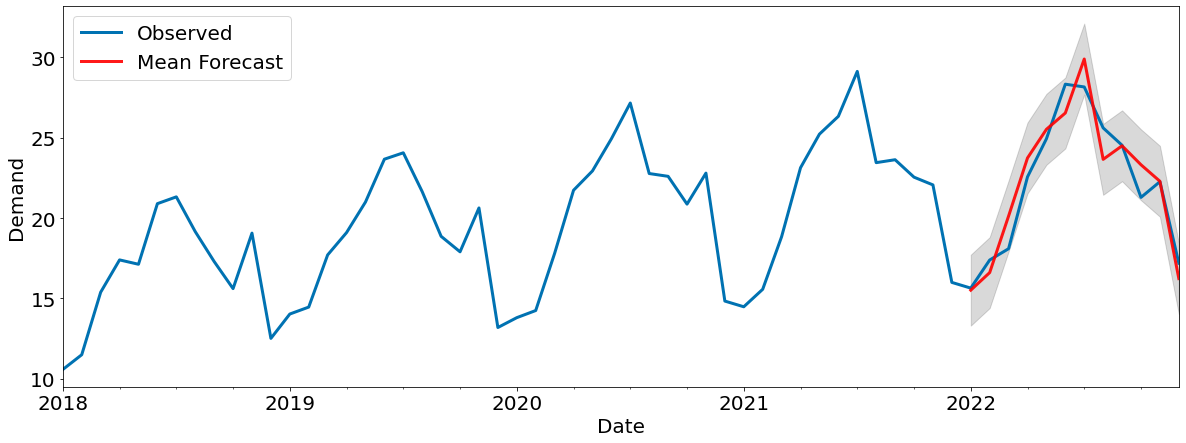

In [116]:
ax = demand_ts['2014':].plot(label='Observed', linewidth = 3, figsize=(20, 7))
pred.predicted_mean.plot(ax=ax, label='Mean Forecast', linewidth = 3, alpha=0.9, color = 'r')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.15)

ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Demand', fontsize = 20)
plt.legend(loc = 'upper left', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [117]:
# Get forecast 12 months ahead in future
forcast_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
forcast_ci = forcast_uc.conf_int()
forcast_ci.head(10)

,lower Daily_Demand,upper Daily_Demand
2023-01-01,13.979691,18.390815
2023-02-01,15.558290,20.175153
2023-03-01,16.281789,21.044051
2023-04-01,20.675778,25.576172
2023-05-01,22.967287,28.001841
2023-06-01,26.215127,31.380345
2023-07-01,26.089086,31.381744
2023-08-01,23.362793,28.779892
2023-09-01,22.269031,27.807778
2023-10-01,19.046292,24.704070


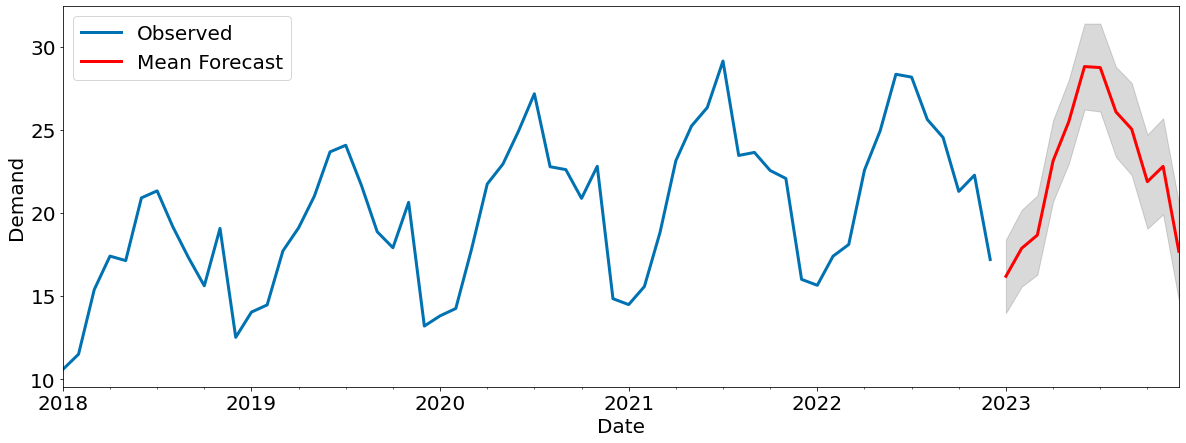

In [118]:
ax = demand_ts.plot(label='Observed', linewidth = 3, figsize=(20, 7))
forcast_uc.predicted_mean.plot(ax=ax, label='Mean Forecast', linewidth = 3,color = 'r')
ax.fill_between(forcast_ci.index,
                forcast_ci.iloc[:, 0],
                forcast_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Demand', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc = 'upper left', fontsize=20)
plt.show()

### Find the Mean and Standard Deviation of the forcast demand

In [119]:
demand_forcast = forcast_ci.copy()
demand_forcast['Mean_Daily_Demand'] = demand_forcast[['lower Daily_Demand', 'upper Daily_Demand']].mean(axis=1)
demand_forcast['Std_Daily_Demand'] = \
demand_forcast.apply(lambda x: (x['upper Daily_Demand'] - x['lower Daily_Demand'])/4, axis=1)
demand_forcast

,lower Daily_Demand,upper Daily_Demand,Mean_Daily_Demand,Std_Daily_Demand
2023-01-01,13.979691,18.390815,16.185253,1.102781
2023-02-01,15.558290,20.175153,17.866721,1.154216
2023-03-01,16.281789,21.044051,18.662920,1.190566
2023-04-01,20.675778,25.576172,23.125975,1.225099
2023-05-01,22.967287,28.001841,25.484564,1.258638
2023-06-01,26.215127,31.380345,28.797736,1.291305
2023-07-01,26.089086,31.381744,28.735415,1.323164
2023-08-01,23.362793,28.779892,26.071343,1.354275
2023-09-01,22.269031,27.807778,25.038405,1.384687
2023-10-01,19.046292,24.704070,21.875181,1.414445


## Safety Stock Optimization

In [120]:
# Lead time data from file 
leadtime_df = pd.read_csv("lead_time.csv")
leadtime_list = leadtime_df["lead_time"].tolist()
leadtime_list[:20]

[1, 3, 3, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 4, 4, 4, 4, 1, 5, 3]

In [121]:
from statistics import mean, stdev

mu_L = mean(leadtime_list)
sigma_L = stdev(leadtime_list)

print('Mean of lead time = {:.3f}'.format(mu_L))
print('Standard Deviation of lead time = {:.3f}'.format(sigma_L))

Mean of lead time = 3.019
Standard Deviation of lead time = 1.306


### Mean and standard deviation of demand 

In [122]:
mu_D = demand_forcast['Mean_Daily_Demand'].tolist()
sigma_D = demand_forcast['Std_Daily_Demand'].tolist()

### Statistics of lead-time demand:

2023-Jan: EOQ = 62
2023-Feb: EOQ = 65
2023-Mar: EOQ = 67
2023-Apr: EOQ = 74
2023-May: EOQ = 78
2023-Jun: EOQ = 83
2023-Jul: EOQ = 83
2023-Aug: EOQ = 79
2023-Sep: EOQ = 78
2023-Oct: EOQ = 72
2023-Nov: EOQ = 74
2023-Dec: EOQ = 65


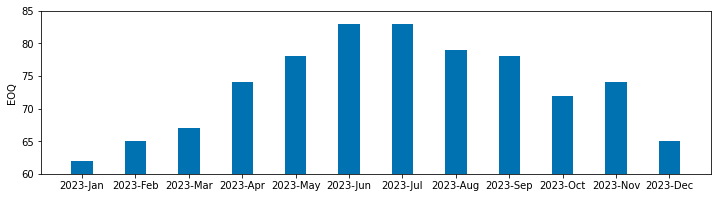

In [125]:
c0 = 12000 # Fixed ordering cost per order
ch = 100 # Holding cost per unit per unit time

EOQ = []
datelist = pd.date_range(demand_forcast.index[0], demand_forcast.index[-1], \
                         freq='MS').strftime("%Y-%b").tolist()
for i, mean_demand_i in enumerate(mu_D):
    #D_L = mean_demand_i*mu_L
    EOQ.append(round(sqrt(2*mean_demand_i*c0/ch)))
    print("{}: EOQ = {}".format(datelist[i], EOQ[-1]))
    
plt.figure(figsize=(12, 3))
plt.bar(np.arange(len(datelist)), EOQ, width = 0.4)
plt.xticks(np.arange(len(datelist)), datelist)
plt.ylim(60, 85)
plt.ylabel('EOQ')
plt.show()

## Calculation of Reorder point (ROP) and Safety Stock (SS)

In [126]:
alpha_list = np.linspace(0.90, 0.99, 10)
print(alpha_list)

[0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


In [127]:
SS = [[]]*len(datelist)
ROP = [[]]*len(datelist)
for i, (mean_demand_i, std_demand_i) in enumerate(zip(mu_D, sigma_D)):
    SS_row_i = []
    ROP_row_i = []
    D_L = mean_demand_i*mu_L
    for alpha in alpha_list:
        z_value = norm.ppf(alpha)
        SS_value = z_value*sqrt(mu_L*(std_demand_i**2) + (mean_demand_i**2)*(sigma_L**2))
        SS_row_i.append(round(SS_value))
        
        # Reorder point (ROP) = Expected demand during lead time (D_L) + Safety stock (SS)
        ROP_row_i.append(round(D_L + SS_value))
    
    SS[i] = SS_row_i
    ROP[i] = ROP_row_i

In [128]:
# Safety stock (SS)
SS_df = pd.DataFrame(SS)
SS_df.columns = [r'$\alpha$ = {:.2f}'.format(x) for x in alpha_list]
SS_df.index = datelist
SS_df

,$\alpha$ = 0.90,$\alpha$ = 0.91,$\alpha$ = 0.92,$\alpha$ = 0.93,$\alpha$ = 0.94,$\alpha$ = 0.95,$\alpha$ = 0.96,$\alpha$ = 0.97,$\alpha$ = 0.98,$\alpha$ = 0.99
2023-Jan,27,28,30,31,33,35,37,40,44,49
2023-Feb,30,31,33,35,36,39,41,44,48,54
2023-Mar,31,33,34,36,38,40,43,46,50,57
2023-Apr,39,41,43,45,47,50,53,57,62,70
2023-May,43,45,47,49,52,55,58,63,68,78
2023-Jun,48,51,53,56,59,62,66,71,77,88
2023-Jul,48,50,53,55,58,62,66,71,77,87
2023-Aug,44,46,48,50,53,56,60,64,70,79
2023-Sep,42,44,46,48,51,54,57,62,67,76
2023-Oct,37,38,40,42,45,47,50,54,59,67


In [129]:
# Reorder Point (ROP)
ROP_df = pd.DataFrame(ROP)
ROP_df.columns = [r'$\alpha$ = {:.2f}'.format(x) for x in alpha_list]
ROP_df.index = datelist
ROP_df

,$\alpha$ = 0.90,$\alpha$ = 0.91,$\alpha$ = 0.92,$\alpha$ = 0.93,$\alpha$ = 0.94,$\alpha$ = 0.95,$\alpha$ = 0.96,$\alpha$ = 0.97,$\alpha$ = 0.98,$\alpha$ = 0.99
2023-Jan,76,77,79,80,82,84,86,89,92,98
2023-Feb,84,85,87,89,90,92,95,98,102,108
2023-Mar,88,89,91,92,94,97,99,102,107,113
2023-Apr,109,110,112,115,117,120,123,127,132,140
2023-May,120,122,124,126,129,132,135,140,145,155
2023-Jun,135,137,140,143,146,149,153,158,164,175
2023-Jul,135,137,140,142,145,149,153,157,164,174
2023-Aug,122,124,127,129,132,135,138,143,149,158
2023-Sep,118,120,122,124,127,130,133,137,143,152
2023-Oct,103,104,106,108,111,113,116,120,125,133


### Plotting SS and ROP in a chart

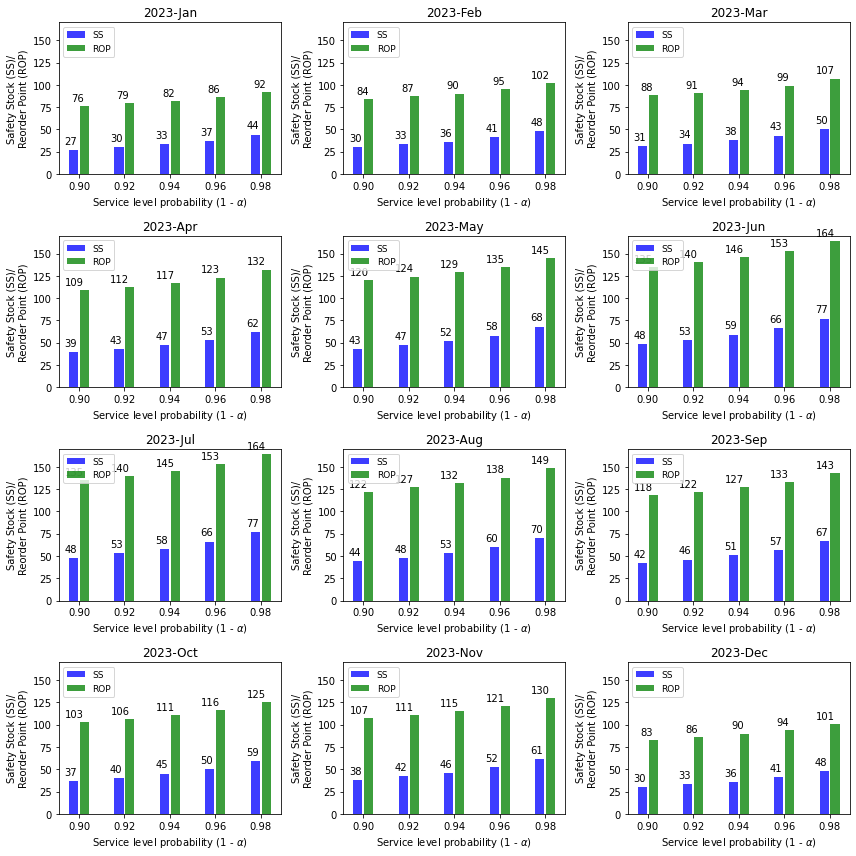

In [134]:
fig1 = plt.figure(figsize=(12, 12))
#colors = ['b', 'r', 'g', 'm']*len(datelist)
skip = 2
for i in range(len(datelist)):

    SS_monthly_list = SS_df.iloc[i,:].tolist()
    ROP_monthly_list = ROP_df.iloc[i,:].tolist()

    ax = plt.subplot(4,3,i+1)
#     plt.plot(alpha_list, SS_monthly_list, 'bD-', label = 'Safety Stock (SS)', linewidth = 1.5)
#     plt.plot(alpha_list, ROP_monthly_list, 'go-', label = 'Reorder Point (ROP)', linewidth = 1.5)
    
    ax.bar(alpha_list[::skip]-0.0012*skip, SS_monthly_list[::skip], width=0.002*skip, color='b',\
           align='center', label = 'SS', alpha = 0.76)
    ax.bar(alpha_list[::skip]+0.0012*skip, ROP_monthly_list[::skip], width=0.002*skip, color='g',\
           align='center',label = 'ROP', alpha = 0.76)
    
    for x, y, z in zip(alpha_list[::skip], SS_monthly_list[::skip], ROP_monthly_list[::skip]):
        plt.annotate(y, xy=(x, y), xytext=(-2, 4),\
            textcoords='offset points', ha='right', va='bottom')
        plt.annotate(z, xy=(x, z), xytext=(5, 3),\
            textcoords='offset points', ha='right', va='bottom')

    plt.xlabel('Service level probability (1 - $\\alpha$)', fontsize = 10)
    plt.ylabel('Safety Stock (SS)/'+'\n'+'Reorder Point (ROP)', fontsize = 10)
    plt.ylim(0, 170)
    plt.legend(loc = 'upper left', fontsize = 9)
    ax.set_title(datelist[i])

plt.tight_layout()
plt.show()